In [ ]:
import pandas as pd


file_path = '/content/data.csv'

try:
    data = pd.read_csv(
        file_path,
        error_bad_lines=False,
        warn_bad_lines=True
    )
except Exception as e:
    print(f"An error occurred: {e}")


data = data.dropna(subset=['start_station_name', 'end_station_name', 'start_station_id', 'end_station_id'])

for col in ['start_station_name', 'end_station_name', 'start_station_id', 'end_station_id']:
    data[col] = data[col].astype(str)


data = data[data['rideable_type'] != 'electric_bike']


data['ride_duration'] = (pd.to_datetime(data['ended_at']) - pd.to_datetime(data['started_at'])).dt.total_seconds()


data = data[data['start_station_name'] != data['end_station_name']]


data['station_pair'] = data.apply(
    lambda row: tuple(sorted([row['start_station_name'], row['end_station_name']])),
    axis=1
)


grouped = data.groupby('station_pair')


results = grouped.filter(lambda x: len(x) > 1).groupby('station_pair').agg({
    'ride_duration': 'median',
    'start_station_name': 'first',
    'end_station_name': 'first',
    'start_station_id': 'first',
    'end_station_id': 'first',
    'start_lat': 'first',
    'start_lng': 'first',
    'end_lat': 'first',
    'end_lng': 'first'
}).rename(columns={'ride_duration': 'median_ride_duration (seconds)'})


results = results.reset_index(drop=True)

print(results)


<ipython-input-4-f1686a3fb40c>:8: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(
<ipython-input-4-f1686a3fb40c>:8: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(
<ipython-input-4-f1686a3fb40c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].astype(str)


      median_ride_duration (seconds)          start_station_name  \
0                               90.0      *Howard St at Grace St   
1                              360.0      *Howard St at Grace St   
2                              570.0      *Howard St at Grace St   
3                              870.0       2nd St at Townsend St   
4                              750.0      *Howard St at Grace St   
...                              ...                         ...   
9955                           900.0       Webster St at Clay St   
9956                           240.0  Webster St at O'Farrell St   
9957                           840.0  Webster St at O'Farrell St   
9958                          1110.0   West St at University Ave   
9959                           480.0        Willow St at Vine St   

                                       end_station_name start_station_id  \
0                                  11th St at Natoma St         SF-K24-3   
1                              

In [ ]:
results.head(50)

,median_ride_duration (seconds),start_station_name,end_station_name,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng
0,90.0,*Howard St at Grace St,11th St at Natoma St,SF-K24-3,SF-K24,37.774479,-122.413914,37.773507,-122.416040
1,360.0,*Howard St at Grace St,14th St at Mission St,SF-K24-3,SF-M22-1,37.774479,-122.413914,37.768227,-122.420359
2,570.0,*Howard St at Grace St,19th St at Florida St,SF-K24-3,SF-O25-1,37.774479,-122.413914,37.760447,-122.410807
3,870.0,2nd St at Townsend St,*Howard St at Grace St,SF-I30,SF-K24-3,37.780526,-122.390288,37.774479,-122.413914
4,750.0,*Howard St at Grace St,3rd St at Townsend St,SF-K24-3,SF-J29-1,37.774479,-122.413914,37.778588,-122.392553
5,300.0,*Howard St at Grace St,8th St at Brannan St,SF-K24-3,SF-K26,37.774479,-122.413914,37.771431,-122.405787
6,150.0,8th St at Ringold St,*Howard St at Grace St,SF-J24,SF-K24-3,37.774520,-122.409449,37.774479,-122.413914
7,540.0,*Howard St at Grace St,Dolores St at 15th St,SF-K24-3,SF-M21,37.774479,-122.413914,37.766100,-122.426659
8,780.0,*Howard St at Grace St,Duboce Park,SF-K24-3,SF-L19,37.774479,-122.413914,37.769223,-122.434062
9,750.0,Embarcadero BART Station (Beale St at Market St),*Howard St at Grace St,SF-E29-3,SF-K24-3,37.792251,-122.397086,37.774479,-122.413914


In [ ]:

results.to_csv('final_ride_durations.csv', index=False)


from google.colab import files
files.download('final_ride_durations.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

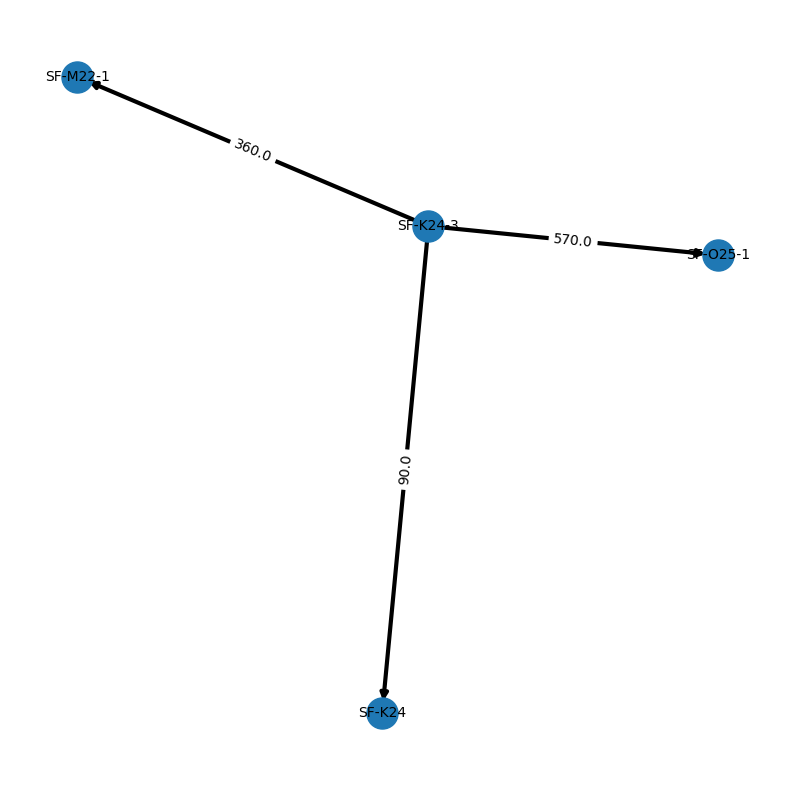

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


data = pd.read_csv('/content/final_ride_durations.csv')
data = data.head(3)

G = nx.DiGraph()


for index, row in data.iterrows():
    G.add_edge(row['start_station_id'], row['end_station_id'], weight=row['median_ride_duration (seconds)'])


plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, width=3)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.axis('off')
plt.show()


In [ ]:
import folium
import pandas as pd


data = pd.read_excel('/content/sample.xlsx')




map_center = [data['start_lat'].mean(), data['start_lng'].mean()]
map = folium.Map(location=map_center, zoom_start=13)


for idx, row in data.iterrows():

    folium.Marker(
        location=[row['start_lat'], row['start_lng']],
        popup=f'Start: {row["start_station_name"]}',
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map)


    folium.Marker(
        location=[row['end_lat'], row['end_lng']],
        popup=f'End: {row["end_station_name"]}',
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(map)

map



